# Template

In [37]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import descartes
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
from shapely import geometry

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing

## Getting and describing the data

In [13]:
def get_local_repository_path(repository_name):
    """
    Return local absolute path from home directory
    to the repository folder (including it).
    Arg.: Name of the repository.
    """
    wd_path = os.getcwd()
    split_wd_path = wd_path.split("/")
    tfm_position = split_wd_path.index(repository_name)
    local_path_split = split_wd_path[:tfm_position+1]
    return "/".join(local_path_split)

In [14]:
# CONFIGURE
local_path = get_local_repository_path("tfm")
model_name = "example"

In [15]:
# OUTPUTS
save_dir = os.path.join(os.path.abspath(os.getcwd()), "outputs", model_name)
# Create outputs folder
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

In [26]:
# DATA SET DIRECTORY
source_dir = "data/geodata/preprocessing"
# Importing the dataset
dataset = pd.read_csv(os.path.join(local_path, source_dir, "filtered_coordinates.csv"))
dataset[:5]

,species_name,latitude,longitude,coordinate_uncertainty
0,Alnus glutinosa,53.523295,-2.630142,6.0
1,Alnus glutinosa,53.037265,-0.825083,5.0
2,Alnus glutinosa,53.778151,-2.215379,3.0
3,Alnus glutinosa,53.552534,-2.627071,899.0
4,Alnus glutinosa,53.040065,-0.821489,5.0


In [55]:
dataset = dataset.drop(columns="coordinate_uncertainty")
dataset[:5]

,species_name,latitude,longitude
0,Alnus glutinosa,53.523295,-2.630142
1,Alnus glutinosa,53.037265,-0.825083
2,Alnus glutinosa,53.778151,-2.215379
3,Alnus glutinosa,53.552534,-2.627071
4,Alnus glutinosa,53.040065,-0.821489


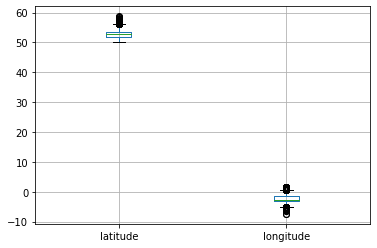

In [56]:
dataset.boxplot()

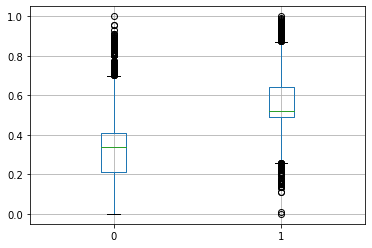

In [69]:
# Effect of features normalization
dataset_no_sp = dataset.drop(columns="species_name")
x = dataset_no_sp.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_norm = pd.DataFrame(x_scaled)
dataset_norm.boxplot()

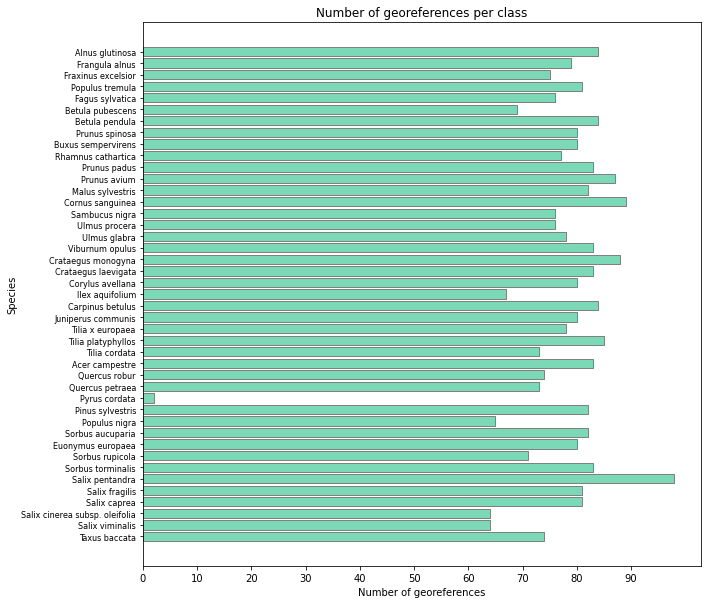

In [33]:
def get_species_list(df):
    return df["species_name"].tolist()

def get_occurrence_count(item_list):
    item_count = []
    unique_items = unique(item_list)
    for item in unique_items:
        item_count.append(item_list.count(item))
    return item_count

def unique(item_list):
    unique_list = []
    for item in item_list:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def plot_coordenates_count(occurrence_count, species_name, path_to_plot):
    """
    Plot number of coordenates per class.
    """
    occurrence_count = list(reversed(occurrence_count))
    species_name = list(reversed(species_name))
    plt.figure(figsize=(10,10)) 
    plt.barh(species_name, occurrence_count, color="#7cd9b7", height=0.8, edgecolor="grey")
    plt.title("Number of georeferences per class")
    # x axis, species
    xint = range(0,(max(occurrence_count)+1),10)
    plt.xticks(xint)
    plt.xlabel("Number of georeferences")
    # y axis, image count
    plt.ylabel("Species", rotation="vertical")
    plt.yticks(fontsize=8)
    # save file
    plt.savefig(path_to_plot)

species_name = unique(get_species_list(dataset))
occurrence_count = get_occurrence_count(get_species_list(dataset))   
plot_coordenates_count(occurrence_count, species_name, os.path.join(save_dir, "occurrences_per_class.png"))

There is class imbalance. I suggest eliminating Pyrus cordata class.

No handles with labels found to put in legend.


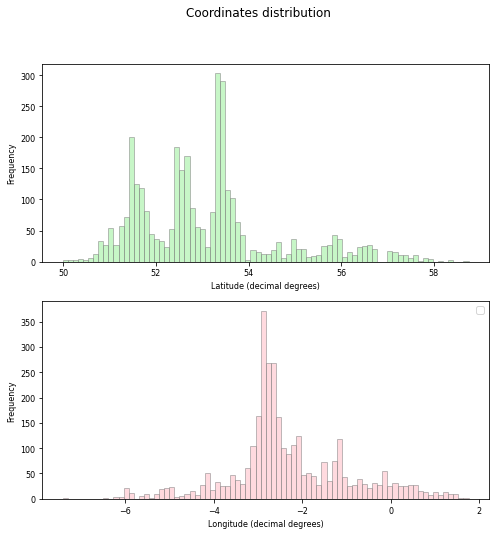

In [45]:
def column_to_list(df, column):
    """
    Return a list of elements of column from a data frame.
    Args.: a dataframe and a name of a column.
    """
    try:
        return df[column].tolist()
    except:
        print(f"Unable to extract {column} from {df}.")

def plot_coordinates_frequency(coordinates_df, destination_path):
    """
    Return an histogram with the frequency of the coordinates.
    Arg.: a data frame with latitude and longitude
    """
    latitude = column_to_list(coordinates_df, "latitude")
    longitude = column_to_list(coordinates_df, "longitude")
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(8, 8))
    #fig, axs = plt.subplots(2)
    fig.suptitle('Coordinates distribution')
    plt.subplot(2,1,1)
    plt.hist(latitude, bins = 80, alpha = 0.5, 
             color="lightgreen", 
             edgecolor="grey")
    plt.ylabel("Frequency", fontsize=8)
    plt.xlabel("Latitude (decimal degrees)", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.subplot(2,1,2)
    plt.hist(longitude, bins = 80, alpha = 0.5, 
            color="lightpink", 
            edgecolor="grey")
    plt.ylabel("Frequency", fontsize=8)
    plt.xlabel("Longitude (decimal degrees)", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()
    plt.savefig(destination_path)
    
plot_coordinates_frequency(dataset,os.path.join(save_dir, "histogram.png"))

/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


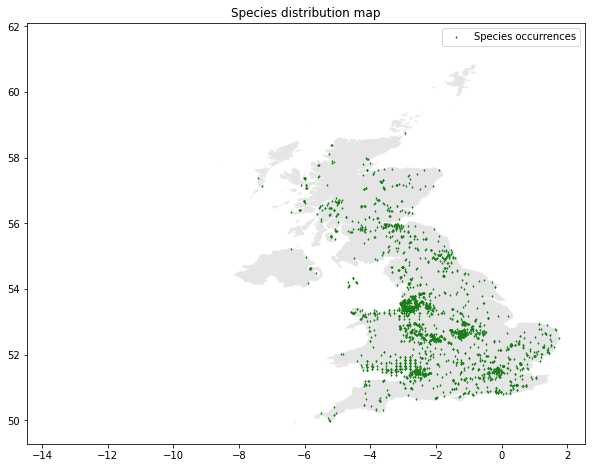

In [19]:
# UK map
shape_file = os.path.join(local_path,"data/geodata/uk_maps/GBR_adm0.shp") # UK map

def plot_occurrences_map(coordinates_df, shape_file, destination_path):
    """
    Return an occurrences map in .png format.
    Args.: a shape file for a geographical area
    and a dataframe with at least two columns:
    - latitude
    - longitde
    and a path where to save the map.    
    """
    # Add a new column to the data frame with a combination of coordinates
    coordinate_pair = [Point(xy) for xy in zip(coordinates_df.longitude, coordinates_df.latitude)]
    coordinates_df['geometry'] = coordinate_pair
    coordinates_df.drop(['latitude','longitude'], axis = 1, inplace=True)
    crs = {'init': 'epsg:4326'}
    occurrences_loc = gpd.GeoDataFrame(coordinates_df, crs=crs, geometry=coordinate_pair)
    occurrences_loc.shape
 
    shape_map = gpd.read_file(shape_file)
    fig, ax = plt.subplots(figsize = (10,10))
    occurrences_loc.geometry.plot(marker="d", color="green", markersize=1, ax=ax, label = "Species occurrences")
    shape_map.plot(color="grey", ax=ax, alpha = 0.2)
   
    plt.title('Species distribution map')
    plt.legend()
    plt.savefig(destination_path)
    
plot_occurrences_map(dataset, shape_file,os.path.join(save_dir, "occurrences_map.png"))

In [20]:
# LABELS
class_names = list(set(column_to_list(dataset, "species_name")))
print(f"{len(class_names)} classes in dataset.")
print(f"Classes names: {class_names}")

43 classes in dataset.
Classes names: ['Frangula alnus', 'Prunus spinosa', 'Tilia cordata', 'Prunus padus', 'Betula pubescens', 'Acer campestre', 'Quercus robur', 'Buxus sempervirens', 'Malus sylvestris', 'Sorbus rupicola', 'Carpinus betulus', 'Sorbus aucuparia', 'Tilia x europaea', 'Salix pentandra', 'Ilex aquifolium', 'Fraxinus excelsior', 'Corylus avellana', 'Betula pendula', 'Sorbus torminalis', 'Quercus petraea', 'Populus nigra', 'Salix caprea', 'Crataegus monogyna', 'Euonymus europaea', 'Alnus glutinosa', 'Salix cinerea subsp. oleifolia', 'Salix viminalis', 'Ulmus glabra', 'Crataegus laevigata', 'Pyrus cordata', 'Tilia platyphyllos', 'Rhamnus cathartica', 'Juniperus communis', 'Fagus sylvatica', 'Sambucus nigra', 'Ulmus procera', 'Populus tremula', 'Cornus sanguinea', 'Pinus sylvestris', 'Viburnum opulus', 'Taxus baccata', 'Prunus avium', 'Salix fragilis']


In [21]:
# EDIT FOR EACH MODEL
# Model description
model_description = f"""
{model_name}

"""

# Save model description
with open(os.path.join(save_dir,"model_description.txt"), "w") as file:
    with redirect_stdout(file):
        print(model_description)

NameError: name 'redirect_stdout' is not defined

## Retrieving the data from the dataset 

In [22]:
# Encode class names
class_names.sort()
species_to_number = {species_name:class_names.index(species_name) for species_name in class_names}
species_to_number

{'Acer campestre': 0,
 'Alnus glutinosa': 1,
 'Betula pendula': 2,
 'Betula pubescens': 3,
 'Buxus sempervirens': 4,
 'Carpinus betulus': 5,
 'Cornus sanguinea': 6,
 'Corylus avellana': 7,
 'Crataegus laevigata': 8,
 'Crataegus monogyna': 9,
 'Euonymus europaea': 10,
 'Fagus sylvatica': 11,
 'Frangula alnus': 12,
 'Fraxinus excelsior': 13,
 'Ilex aquifolium': 14,
 'Juniperus communis': 15,
 'Malus sylvestris': 16,
 'Pinus sylvestris': 17,
 'Populus nigra': 18,
 'Populus tremula': 19,
 'Prunus avium': 20,
 'Prunus padus': 21,
 'Prunus spinosa': 22,
 'Pyrus cordata': 23,
 'Quercus petraea': 24,
 'Quercus robur': 25,
 'Rhamnus cathartica': 26,
 'Salix caprea': 27,
 'Salix cinerea subsp. oleifolia': 28,
 'Salix fragilis': 29,
 'Salix pentandra': 30,
 'Salix viminalis': 31,
 'Sambucus nigra': 32,
 'Sorbus aucuparia': 33,
 'Sorbus rupicola': 34,
 'Sorbus torminalis': 35,
 'Taxus baccata': 36,
 'Tilia cordata': 37,
 'Tilia platyphyllos': 38,
 'Tilia x europaea': 39,
 'Ulmus glabra': 40,
 'Ulm

In [23]:
dataset['species_num']=dataset.apply(lambda r:species_to_number[r.species_name],axis=1)
X = dataset.iloc[:, 1:4].values  # features
y = dataset.iloc[:, 3].values    # to predict
# one hot encode output variable
y = to_categorical(y)
print(X)
print(y)

[[53.523295 -2.630142  1.      ]
 [53.037265 -0.825083  1.      ]
 [53.778151 -2.215379  1.      ]
 ...
 [53.63715  -2.836575 36.      ]
 [51.467652 -2.627267 36.      ]
 [51.574292 -0.919192 36.      ]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Data normalization

In [59]:
X_train_norm = normalize(X_train)
X_train_norm

array([[ 0.80464109, -0.0458153 ,  0.59199128],
       [ 0.85678859, -0.0457852 ,  0.51363122],
       [ 0.82229437, -0.04401072,  0.56735794],
       ...,
       [ 0.99070775, -0.04571682,  0.12809421],
       [ 0.84608643, -0.0336454 ,  0.53198284],
       [ 0.85756659, -0.08298514,  0.50763472]])

In [60]:
y_train_norm = normalize(y_train)
y_train_norm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Creating and training the model

### Model network architecture

The simplest network architecture constists of 3 layers:

- Input layer, with a number of nodes equal to the number of features in the model.
- Hidden layer, with a variable number of nodes. 
- Output layer, with a number of nodes equal to the number of classes. 

#### The hidden layers

The hidden layers can have different characteristics depending of their use. 
The transformations applied by the convolutional layers have shown the best results for image classification, so they will be the main component in this model.


##### The fully connected layer

A fully connected layer is an all purpose layer where each node receive the inputs from all the nodes from the previous layer, multiplied by their weights, sumed and transformed by the activation funcion.

In keras, the fully connected layer is called `Dense`.



### Creating the model with `Keras`

In `Keras` the model is defined with the `Sequential` method as a linear stack ot layers. The **input layer** is implicit in the first layer (a network with 3 layers will have 2 in `keras Sequential` method).

The **input shape** is into the first layer. The model inputs are the tensors or arrays. Images have 3 dimensions: **width**, **height** and **channels**. The width and the height are measured in pixels and the channels reference the color values (the channel value is 1 if it is in black and white and 3 if it is color in RGB (Red, Green, blue) or HSV (hue, saturation, value) formats - 2 and 4 are black and white or color with an alpha channel (transparency). 

The **activation function** that has to be specified in each layer transforms the input data so that the output doen't have a linear relation with the input. 

### Transfer learning with `Keras`

Aim: to use a pre-existing model that has performed well carrying out a similar task. 


#### VGG16

Ref: 2014 ImageNet competition


### Training the model

The parameters from the model above represent the **weights**. 
A weight is a number that multiplies the value of the **input node** before passing it to the **output node** in the next layer. 
An output node receive the values from each of the input nodes multiplied by their weights, after they have been sumed and transformed by the **activation function**.


Training the model means to adjust the values of the weights in the subsequent runs (the **epochs**. In every run, the weights are modified based on an optimization algorithm or **optimizer**.
This algorithm tries to minimize the **loss function**. In every run, the model predicts the classes with a certain probability. The loss function measures, through that probability, the error of the predictions. In this context, the **gradient** is the computation of the error in relation to the weight (it is the derivative of the error divided into the derivative of the weight). The gradient is multiplied by a **learning rate** to obtain the new weights. The value of the learning rate is in the order of 10^-3.

**Stocastic gradient descent** (sgd) is one type of optimizer. There are also different types of loss functions, like the **sparse categorical crossentropy**. The value of the optimizer 

#### Configuration

- Epoch: the number of iterations through the network in order to adjust the weights. In general, the higher number of epochs, the better the performance, up to a limit. 
- Batch size: the number of examples passed at a time. If the batch size is equal to the number of examples in the training dataset, then we have one batch per epoch. This is computationally costly and may be limited by the machine power. If the batch size is smaller, then there would be several runs per epoch. If it is too small, the training may be too slow.  

### Evaluating the model training

#### Accuracy and loss during training

In [ ]:
# Parameters measured during model training
history_dict = history.history
print(history_dict.keys())

In [ ]:
try:
    acc = history_dict["acc"]
    val_acc = history_dict["val_acc"]
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]
except:
    try:
        acc = history_dict["accuracy"]
        val_acc = history_dict["val_accuracy"]
        loss = history_dict["loss"]
        val_loss = history_dict["val_loss"]
    except:
        pass        

In [ ]:
def plot_acc_loss(acc,val_acc,loss,val_loss,epochs):
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.suptitle(model_name)
    # Accuracy plots
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    # Loss plots
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss") 
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.savefig(os.path.join(save_dir,"acc_loss_plot.png"))
    plt.show()

In [ ]:
plot_acc_loss(acc,val_acc,loss,val_loss,epochs)

#### Overfitting

When the model predicts significantly better the training set than the validation set, it is a sign of overfitting. 

### Reuse model outputs

To load the model again, it has to be built and then the weights added:

```
# load pre-trained model with the weights
vgg16_model = tf.keras.applications.VGG16()
# Add the layers of vgg16 model to a new sequential model 
model = Sequential()
for layer in vgg16_model.layers[:-1]: # remove last layer
    model.add(layer)
# Freeze the weights in the layers
for layer in model.layers:
    layer.trainable = False
# Add last layer for categories
model.add(Dense(len(class_names), activation = "softmax"))  

cnn.load_weights(os.path.join(save_dir, "model.h5"))
```

To get back the accuracy and loss data:

- Open the CSV with the model history.
- Save it to a dictionary.

```
history_df = pd.read_csv(os.path.join(save_dir, "model_history.csv"))
history_dict = history_df.to_dict()
try: # the key names vary across tf versions
    acc = np.array(list(history_dict["acc"].values()))
    val_acc = np.array(list(history_dict["val_acc"].values()))
    loss = np.array(list(history_dict["loss"].values()))
    val_loss = np.array(list(history_dict["val_loss"].values()))
    epochs_range = np.array(range(epochs))
except:
    try:
        acc = np.array(list(history_dict["accuracy"].values()))
        val_acc = np.array(list(history_dict["val_accuracy"].values()))
        loss = np.array(list(history_dict["loss"].values()))
        val_loss = np.array(list(history_dict["val_loss"].values()))
        epochs_range = np.array(range(epochs))
    except:
        pass
plot_acc_loss(acc,val_acc,loss,val_loss,epochs)
```

## Evaluating the model

### Get the test dataset

In [ ]:
def test_labels_to_index(test_labels, class_names):
    """
    Return a 1D array of integers with the corresponding
    number for a class.
    Args.: - A list with the class name of each item in 
          the test data set.
           - A sorted list with the possible class names. 
    Eg.: test_labels[1] = "Buxus_sempervirens" corresponds to index 4
         in the list of class names.
    """
    test_labels_index = []
    for i in range(len(test_labels)):
        ind = class_names.index(test_labels[i])
        test_labels_index.append(ind)
    return np.array(test_labels_index)

In [ ]:
test_files = os.listdir(test_dir)
test_labels = get_test_labels(test_files)
test_labels[:5]

In [ ]:
test_labels_index = test_labels_to_index(test_labels, class_names)
test_labels_index[:5]

### Predict the probability of classifiying each class

In [ ]:
# Get the probability of predicting each class for each image
predictions = model.predict_generator(test_array,steps=1,verbose=1)

Predictions is a 2D array with a shape: (number of examples in test, number of classes)

In [ ]:
predictions.shape

In [ ]:
# Get predicted class for each example
def predicted_class(predictions):
    """
    Return a 1D array with the predicted class for each example.
    Arg.: 2D array predictions of shape (number of examples, number of classes)
    """
    pred_class = []
    for i in range(len(predictions)):
        higher_prob = max(predictions[i])
        ind, = np.where(np.isclose(predictions[i], higher_prob))
        pred_class.append(ind[0])
    return np.array(pred_class)

pred_class = predicted_class(predictions)

### Plot the confussion matrix

In [ ]:
test_labels_index

In [ ]:
pred_class

In [ ]:
# Build the confusion matrix
cm = tf.math.confusion_matrix(test_labels_index, pred_class) 
# Convert from tensor to array
sess = tf.Session()
conf_mat = sess.run(cm)
conf_mat

In [ ]:
def plot_confusion_matrix(cm, class_names, model_name):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
    plt.title("Confusion matrix - "+ model_name, fontsize = 22)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.savefig(os.path.join(save_dir,"conf_matrix.png"))


In [ ]:
plot_confusion_matrix(conf_mat, np.array(class_names), model_name)